# Importing libraries

In [34]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Standard libraries
import time
import math
import random
import itertools

# Scientific and data processing libraries
import numpy as np
import pandas as pd
from scipy.special import comb

# Graph and clustering libraries
import networkx as nx
import metis
import distinctipy

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

# Progress bar
from tqdm import tqdm

# Machine learning and metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score, normalized_mutual_info_score

# Dataset

<AxesSubplot:>

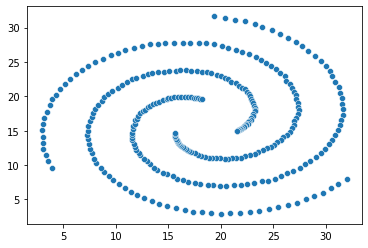

In [35]:
# Load dataset
dataset = pd.read_csv(r'/Users/sajal/Downloads/Ch2++/Standard Benchmark Datasets/3-spiral.csv')

# Clean and rename columns
dataset.columns = dataset.columns.str.lower()
dataset = dataset.rename(columns={'a0': 'x', 'a1': 'y'})

# Set initial parameters
knn = int(math.log(len(dataset)))  # k: number of neighbors in k-NN graph
no = dataset['class'].nunique()         # number of final clusters

# Prepare data
df = dataset[['x', 'y']]
true = dataset['class']
plot = dataset.to_numpy()

# Plot dataset
sns.scatterplot(x=plot[:, 0], y=plot[:, 1])  # Dataset Plot
# sns.scatterplot(x=plot[:, 0], y=plot[:, 1], hue=true)  # Ground-Truth Plot

# k-NN Graph Generation: Exact k-NN

Building k-NN (knn = 5)...


100%|████████████████████████████████████████| 312/312 [00:01<00:00, 224.66it/s]


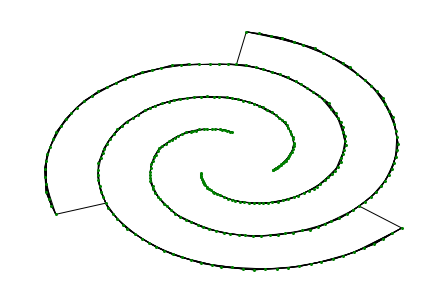

In [36]:
import numpy as np
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt

def euclidean_distance(a, b):
    return np.linalg.norm(np.array(a) - np.array(b))


def knn_graph(df, knn, verbose=False):
    points = [p[1:] for p in df.itertuples()]
    g = nx.Graph()

    for i in range(len(points)):
        g.add_node(i)

    if verbose:
        print(f"Building k-NN (knn = {knn})...")

    iterpoints = tqdm(enumerate(points), total=len(points)) if verbose else enumerate(points)

    for i, p in iterpoints:
        distances = list(map(lambda x: euclidean_distance(p, x), points))
        closests = np.argsort(distances)[1:knn + 1]

        for c in closests:
            if distances[c] == 0:
                continue
            weight = 1.0 / distances[c]
            g.add_edge(i, c, weight=weight, similarity=int(weight * 1e3))

        g.nodes[i]['pos'] = p

    g.graph['edge_weight_attr'] = 'similarity'
    return g


def plot2d_graph(graph):
    pos = nx.get_node_attributes(graph, 'pos')
    nx.draw(graph, pos, node_size=4.3, node_shape='x', node_color='green')
#     plt.savefig('Exact k-NN', dpi=500) # incase to save o/p locally
    plt.show(block=True)


graph = knn_graph(df, knn, verbose=True)
n = graph.number_of_nodes()
m = graph.number_of_edges()
pos = nx.get_node_attributes(graph, 'pos') #co-ordinates of each node
plot2d_graph(graph)

# Graph Partitioning : FM Bisection Algorithm

Total cut size: 1666
Partition 1: [193, 196, 198, 216]
Partition 2: [31, 105, 195]
Partition 3: [56, 179, 192, 224]
Partition 4: [146, 197, 236]
Partition 5: [40, 90, 97, 178, 214]
Partition 6: [15, 48, 102, 137, 263]
Partition 7: [35, 37, 169, 245]
Partition 8: [49, 77, 166, 246]
Partition 9: [86, 168, 237, 278]
Partition 10: [99, 155, 222, 235]
Partition 11: [33, 141, 177, 189]
Partition 12: [115, 154, 211, 212]
Partition 13: [194, 210, 221]
Partition 14: [42, 207, 209, 213]
Partition 15: [18, 157, 172, 223]
Partition 16: [41, 87, 251, 286]
Partition 17: [47, 57, 134]
Partition 18: [74, 131, 258, 260, 295]
Partition 19: [149, 150, 249, 279]
Partition 20: [2, 94, 114, 271, 307]
Partition 21: [7, 183, 185, 219]
Partition 22: [4, 76, 128]
Partition 23: [6, 95, 184, 186]
Partition 24: [5, 205, 218]
Partition 25: [103, 124, 148, 273, 289]
Partition 26: [34, 61, 217, 230, 231]
Partition 27: [21, 23, 24, 25]
Partition 28: [106, 107, 108, 203]
Partition 29: [20, 50, 110, 182]
Partition 30: [

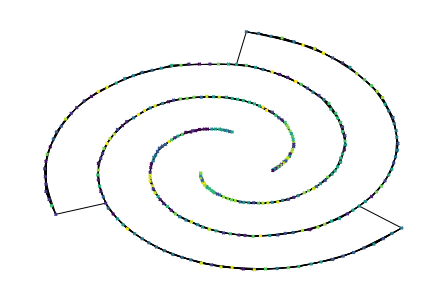

In [37]:
G = graph  # Ensure that graph is defined before this point
start = time.time()

class GainBucket:
    def __init__(self):
        self.buckets = {}

    def add(self, gain, node):
        if gain not in self.buckets:
            self.buckets[gain] = set()
        self.buckets[gain].add(node)

    def remove(self, gain, node):
        if gain in self.buckets and node in self.buckets[gain]:
            self.buckets[gain].remove(node)
            if not self.buckets[gain]:
                del self.buckets[gain]

    def get_max_gain_node(self):
        if not self.buckets:
            return None, None
        max_gain = max(self.buckets)
        node = self.buckets[max_gain].pop()
        if not self.buckets[max_gain]:
            del self.buckets[max_gain]
        return node, max_gain

def cut_size(G, n1, n2):
    """Calculate the cut size (number of edges between nodes in two groups)."""
    return sum(1 for u, v in G.edges if (u in n1 and v in n2) or (u in n2 and v in n1))

def calculate_gains(G, n1, n2):
    """Calculate initial gains for all nodes."""
    gains = {}
    for node in G.nodes:
        internal = sum(1 for neighbor in G.neighbors(node) if neighbor in (n1 if node in n1 else n2))
        external = sum(1 for neighbor in G.neighbors(node) if neighbor in (n2 if node in n1 else n1))
        gains[node] = external - internal
    return gains

def fiduccia_mattheyses(G, n1, n2, max_iter=10):
    """Perform Fiduccia-Mattheyses partitioning to minimize cut size."""
    gains = calculate_gains(G, n1, n2)
    max_gain_bucket = GainBucket()

    for node, gain in gains.items():
        max_gain_bucket.add(gain, node)

    for _ in range(max_iter):
        if not max_gain_bucket.buckets:
            break

        node, max_gain = max_gain_bucket.get_max_gain_node()
        if node is None:
            break

        if node in n1:
            n1.remove(node)
            n2.add(node)
        else:
            n2.remove(node)
            n1.add(node)

        # Update gains
        for neighbor in G.neighbors(node):
            if neighbor in n1:
                old_gain = gains[neighbor]
                new_gain = old_gain - 2
            else:
                old_gain = gains[neighbor]
                new_gain = old_gain + 2

            if neighbor in max_gain_bucket.buckets.get(old_gain, set()):
                max_gain_bucket.remove(old_gain, neighbor)
                max_gain_bucket.add(new_gain, neighbor)
                gains[neighbor] = new_gain

    return cut_size(G, n1, n2), (n1, n2)

def recursive_bisection(G, max_p):
    """Recursively apply Fiduccia-Mattheyses bisection until all partitions have no more than max_p nodes."""
    nodes = list(G.nodes)
    random.shuffle(nodes)
    cut = len(nodes) // 2
    n1 = set(nodes[:cut])
    n2 = set(nodes[cut:])

    def recursive_partition(n1, n2):
        partitions = [n1, n2]
        new_partitions = []
        for part in partitions:
            if len(part) > max_p:
                subgraph = G.subgraph(part).copy()
                sub_nodes = list(subgraph.nodes)
                random.shuffle(sub_nodes)
                sub_cut = len(sub_nodes) // 2
                sub_n1 = set(sub_nodes[:sub_cut])
                sub_n2 = set(sub_nodes[sub_cut:])
                _, (sub_n1, sub_n2) = fiduccia_mattheyses(subgraph, sub_n1, sub_n2)
                new_partitions.extend(recursive_partition(sub_n1, sub_n2))
            else:
                new_partitions.append(part)
        return new_partitions

    _, (n1, n2) = fiduccia_mattheyses(G, n1, n2)
    final_partitions = recursive_partition(n1, n2)
    
    # Store final partitions in 'FM_Partitions' global variable
    global FM_Partitions
    FM_Partitions = final_partitions
    
    return final_partitions

def assign_clusters(G, partitions):
    """Assign cluster labels to graph nodes based on partitions."""
    for i, partition in enumerate(partitions):
        for node in partition:
            G.nodes[node]['cluster'] = i
            
    """Assign cluster labels to graph nodes based on partitions. Indexed by partition number!"""
    partition_map = {}
    for i, partition in enumerate(partitions):
        for node in partition:
            partition_map[node] = i
    
    return [partition_map[node] for node in G.nodes()]

# Ch2 Paper: Parameter max_p: (for FM-Bisection)
n = G.number_of_nodes()
max_p = max(5, n // 100)

# Perform recursive bisection
final_partitions = recursive_bisection(G, max_p)

# Assign clusters to graph nodes and capture partition numbers
partitions = assign_clusters(G, final_partitions)


#Debugging
# # Calculate the cut size for all final partitions
# total_cut_size = sum(cut_size(G, part, set(G.nodes) - part) for part in final_partitions)
# print(f"Total cut size: {total_cut_size}")

# # Output partitions for each node
# for node, partition_number in enumerate(partitions):
#     print(f"Node {node}: Partition {partition_number}")

# # Assign clusters to graph nodes
# assign_clusters(G, final_partitions)


# Calculate the cut size for all final partitions
total_cut_size = sum(cut_size(G, part, set(G.nodes) - part) for part in final_partitions)
print(f"Total cut size: {total_cut_size}")
for i, part in enumerate(final_partitions, 1):
    print(f"Partition {i}: {sorted(part)}")
    
print("Partitioned in:", time.time() - start, "seconds")

# Define colors based on clusters
colors = [G.nodes[node]['cluster'] for node in G.nodes()]
nx.draw(G, pos, node_size=7, node_shape='x', node_color=colors)

# Store the number of partitions obtained, in the variable 'part'
part = len(final_partitions)
print(f"Number of partitions: {part}")
if 'df' in globals() and df is not None:
    df['cluster'] = nx.get_node_attributes(G, 'cluster').values()
    
# Assign the graph back to 'graph' variable
graph = G

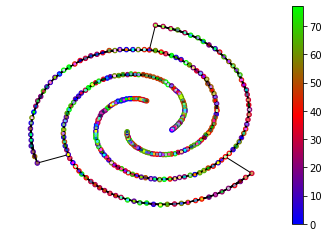

#Partitions generated post hMETIS: 78


In [38]:
# Visualize Partitions
df.plot(kind='scatter', x=0, y=1, c=df['cluster'], cmap='brg')

# Color nodes based on partitions
colors = distinctipy.get_colors(part)
clusters = nx.get_node_attributes(graph, 'cluster').values()
c = [colors[i % len(colors)] for i in clusters]

nx.draw(graph, pos, node_size=4.3, node_color=c, node_shape='x')
plt.show(block=True)

print("#Partitions generated post hMETIS:", part)

# Optimal/Custom Visualization

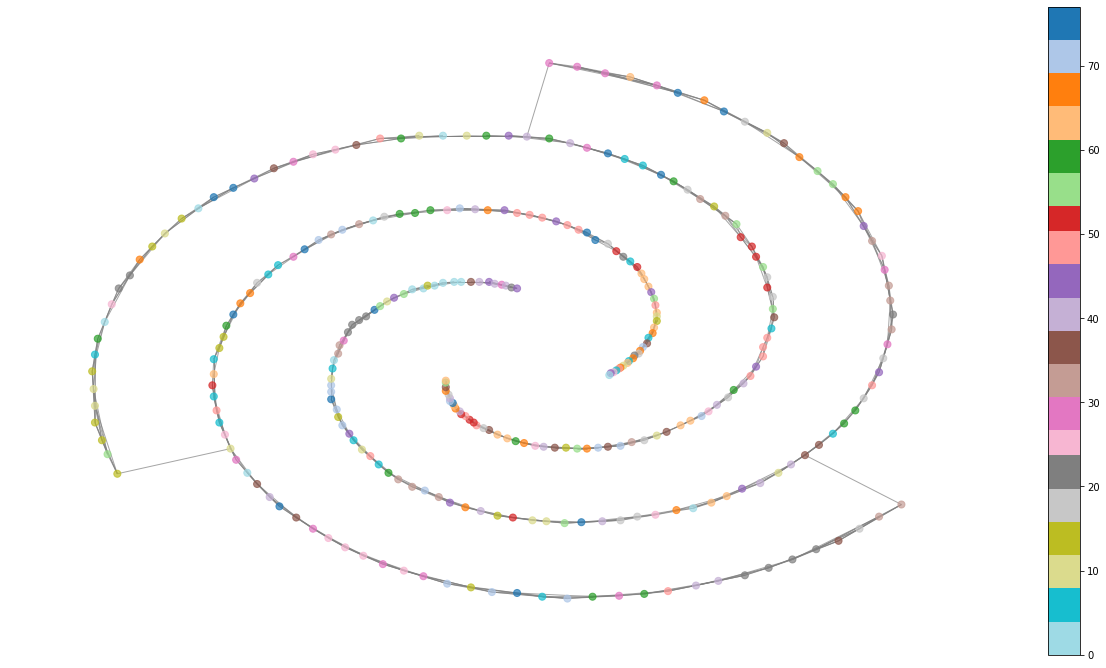

In [39]:
# Generate a color map
unique_clusters = df['cluster'].unique()  # Get unique cluster labels
num_clusters = len(unique_clusters)  # Count the number of unique clusters
cmap = cm.get_cmap('tab20_r', num_clusters)  # Use a colormap with distinct colors

# Map nodes to colors based on their cluster
node_colors = [cmap(i) for i in nx.get_node_attributes(graph, 'cluster').values()]

plt.figure(figsize=(17, 9))
nx.draw(
    graph, 
    pos, 
    node_size=50,  # Adjust node size for visibility
    node_color=node_colors, 
    edge_color='gray',  # Set edge color
    alpha=0.7,  # Slightly transparent edges for a cleaner look
    with_labels=False  # Omit labels for better readability in larger graphs
)

# plt.title("hMETIS : #partitions = 14", fontsize=16)
plt.colorbar(cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=num_clusters - 1)))
plt.show()

# Partition Refinement : Flood Fill

In [40]:
# Initialize empty partitions based on the number of partitions
ff = [[] for _ in range(part)]

# Assign nodes to corresponding partitions: # use 'partitions' variable for FM and 'hmetis' for hMETIS partitioning
for i, val in enumerate(partitions):
    ff[val].append(i)

# Function to refine partitions by connected components
def refine_partitions(graph, partition_indices):
    partitions = []
    for cluster_nodes in partition_indices:
        subgraph = graph.subgraph(cluster_nodes)  # Create subgraph for each partition
        connected_components = list(nx.connected_components(subgraph))  # Find connected components
        partitions.extend(connected_components)  # Add connected components to the partitions list
    return partitions

# Refine the partitions based on connected components
refined_partitions = refine_partitions(graph, ff)

# Get the number of refined partitions
part = len(refined_partitions)

# Update the node attributes with the refined partition information
for i, nodes in enumerate(refined_partitions):
    for node in nodes:
        graph.nodes[node]['cluster'] = i

# Update the DataFrame with the new cluster information
df['cluster'] = nx.get_node_attributes(graph, 'cluster').values()

In [41]:
# Better to skip: As #FM based partitons post Flood-Fill exceeds a lot, usually approaches (n)
# colors = distinctipy.get_colors(part)
# c = [colors[i % (len(colors))] for i in nx.get_node_attributes(graph, 'cluster').values()]
# nx.draw(graph, pos, node_size=4.3, node_color=c, node_shape='x')
# plt.show(block=True)

# print("#Partitions post Flood-Fill:", len(df['cluster'].unique()))

# Parameter Check

In [42]:
print(f"no (final #clusters): {no}")
print(f"knn (k nearest neighbors): {knn}")
print(f"part (#partitions post flood fill): {part}")
print(f"n (#nodes): {n}")
print(f"m (#edges): {m}")

no (final #clusters): 3
knn (k nearest neighbors): 5
part (#partitions post flood fill): 283
n (#nodes): 312
m (#edges): 865


# Merging Criteria: Ch2

In [43]:
def get_cluster(graph, clusters):
    nodes = [n for n in graph.nodes if graph.nodes[n]['cluster'] in clusters]
    return nodes

def connecting_edges(partitions, graph):
    cut_set = []
    for a in partitions[0]:
        for b in partitions[1]:
            if a in graph:
                if b in graph[a]:
                    cut_set.append((a, b))
    return cut_set

def get_weights(graph, edges):
    return [graph[edge[0]][edge[1]]['weight'] for edge in edges]

def s_ci(graph, cluster):
    cluster = graph.subgraph(cluster)
    edges = cluster.edges()
    weights = get_weights(cluster, edges)
    return np.sum(weights)


def E_ci(graph,cluster):
    cluster = graph.subgraph(cluster)
    edges = cluster.edges()
    return len(edges)

def s_ci_avg(graph, cluster):
    sci = s_ci(graph, cluster)
    Eci = E_ci(graph, cluster)
    return (sci/Eci)

def s_cij_avg(graph, cluster_i, cluster_j):
    edges = connecting_edges((cluster_i, cluster_j), graph)
    weights = get_weights(graph, edges)
    return np.mean(weights)

def E_cij(graph, cluster_i, cluster_j):
    edges = connecting_edges((cluster_i, cluster_j), graph)
    return len(edges)

def p_cij(graph, cluster_i, cluster_j):
    scia = s_ci_avg(graph, cluster_i)
    scja = s_ci_avg(graph, cluster_j)
    min_sci_scj_a = min(scia, scja)
    max_sci_scj_a = max(scia, scja)
    return (min_sci_scj_a/max_sci_scj_a)

def rc(graph, cluster_i, cluster_j):
    eci = E_ci(graph, cluster_i)
    ecj = E_ci(graph, cluster_j)
    sci = s_ci(graph, cluster_i)
    scj = s_ci(graph, cluster_j)
    scija = s_cij_avg(graph, cluster_i, cluster_j)
    common_fact = scija/(sci + scj)
    
    rcl_val = 0
    mfact = 1e3
    if (eci==0 or ecj==0):
        rcl_val = mfact* common_fact
    else:
        rcl_val = (eci + ecj)*common_fact
    return rcl_val

def ri(graph, cluster_i, cluster_j):
    eci = E_ci(graph, cluster_i)
    ecj = E_ci(graph, cluster_j)
    ecij = E_cij(graph, cluster_i, cluster_j)
    pcij = p_cij(graph, cluster_i, cluster_j)
    
    ri_val = 0
    beta = 1.0  # default parameter value: Beta = 1.0
    if (eci==0 or ecj==0):
        ri_val = 1
    else:
        ri_val = (ecij/(min(eci, ecj))) * np.power(pcij, beta)
    return ri_val

def merge_score(g, ci, cj, a):
    return ri(g, ci, cj) * np.power(rc(g, ci, cj), a)

def merge_best(graph, df, a, k, verbose=False):
    clusters = np.unique(df['cluster'])
    max_score = 0
    ci, cj = -1, -1
    if len(clusters) <= k:
        return False

    for combination in itertools.combinations(clusters, 2): # Write a heuristic* [use priority queue, rather than brute force]
        i, j = combination
        if i != j:
            if verbose:
                print("Checking c%d c%d" % (i, j))
            gi = get_cluster(graph, [i])
            gj = get_cluster(graph, [j])
            edges = connecting_edges(
                (gi, gj), graph)
            if not edges:
                continue
            ms = merge_score(graph, gi, gj, a)
            if verbose:
                print("Merge score: %f" % (ms))
            if ms > max_score:
                if verbose:
                    print("Better than: %f" % (max_score))
                max_score = ms
                ci, cj = i, j

    if max_score > 0:
        if verbose:
            print("Merging c%d and c%d" % (ci, cj))
        df.loc[df['cluster'] == cj, 'cluster'] = ci
        for i, p in enumerate(graph.nodes()):
            if graph.nodes[p]['cluster'] == cj:
                graph.nodes[p]['cluster'] = ci
    return max_score > 0

In [44]:
start = time.time()
# Iterate over the number of partitions left to merge
iterm = tqdm(enumerate(range(part - no)), total=part - no)
for i in iterm:
    merge_best(graph, df, 2.0, no, False) # default parameter value: Alpha = 2.0
print(f"Merged in {time.time() - start:.2f} seconds")

clusters = len(np.unique(df['cluster']))
print(f"Number of clusters after merging: {clusters}")

100%|█████████████████████████████████████████| 280/280 [24:12<00:00,  5.19s/it]

Merged in 1452.54 seconds
Number of clusters after merging: 3


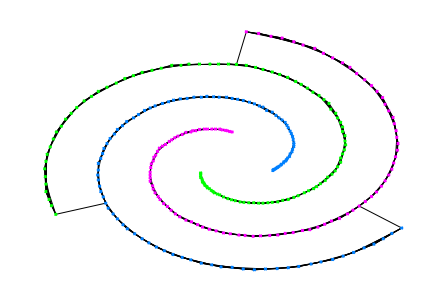

In [45]:
# Automatically determine the maximum number of colors needed based on the number of clusters
max_color = clusters
colors = distinctipy.get_colors(max_color)
c = [colors[i % len(colors)] for i in nx.get_node_attributes(graph, 'cluster').values()]
nx.draw(
    graph,
    pos,
    node_size=6.3,
    node_color=c,
    node_shape='x'
)
plt.show(block=True)

In [46]:
# Function to rebuild cluster labels and reassign them incrementally
def rebuild_labels(df):
    ans = df.copy()  # Create a copy of the DataFrame
    clusters = list(pd.DataFrame(df['cluster'].value_counts()).index)  # Get list of unique clusters
    c = 1  # Initialize the new label counter
    for i in clusters:
        # Reassign the 'cluster' label incrementally
        ans.loc[df['cluster'] == i, 'cluster'] = c
        c += 1  # Increment the counter for the next label
    return ans

# Rebuild labels for the DataFrame
ans = rebuild_labels(df)

# Standardize the features 'x' and 'y' using StandardScaler
z = StandardScaler()
score = dataset[['x', 'y']]
score[['x', 'y']] = z.fit_transform(score)

# Extract predicted cluster labels
predicted = ans['cluster'].to_numpy()

# Calculate and print evaluation metrics
print("NMI-Score:", normalized_mutual_info_score(true, predicted))
print("Rand-Score:", adjusted_rand_score(true, predicted))

NMI-Score: 1.0
Rand-Score: 1.0
